# Udacity CarND Project 4: Advanced Lane Detection

## Camera Calibration
It is important to calibrate the camera before processing the rest of the images and the video. 
Lets use 20 calibration images from 'camera_cal' folder.

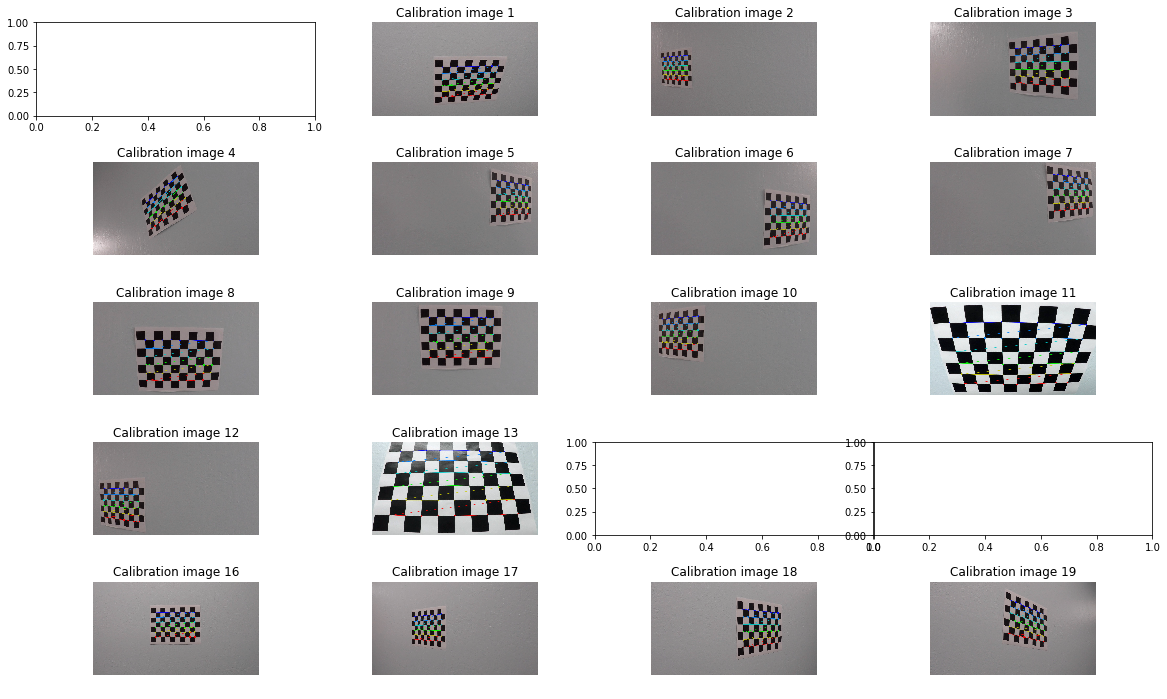

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx=9 #No of chessboard corners in x axis
ny=6 #No of chessboard corners in y axis

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #Except the Z dimension, make a grid for the chessboard points

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(20, 12))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        axs[idx].axis('off')
        axs[idx].set_title('Calibration image '+ str(idx))
        axs[idx].imshow(img)

*Empty plots above mean OpenCV couldn't find chessboard corners in those images.

## Finding Distortion Coefficients and Camera Matrix
Lets find the values and pickle them for easy access.
Then test the undistortion function on the test images 

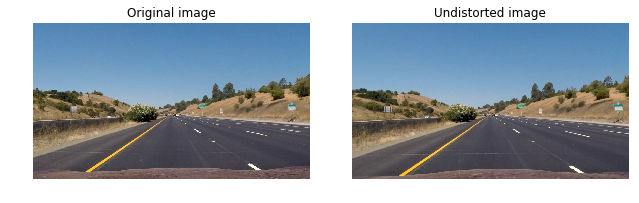

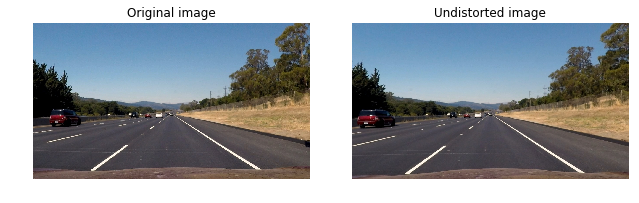

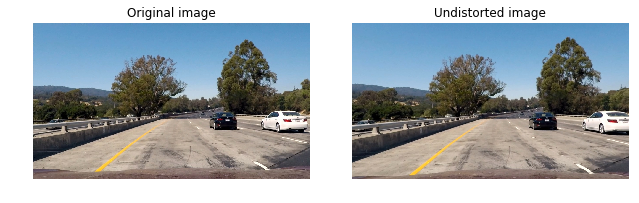

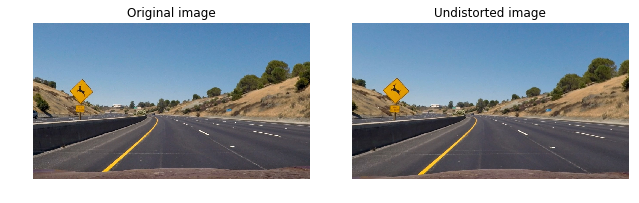

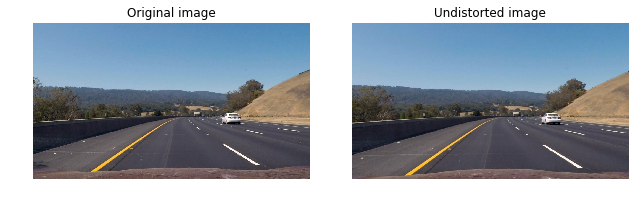

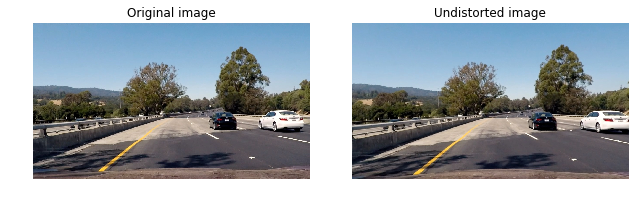

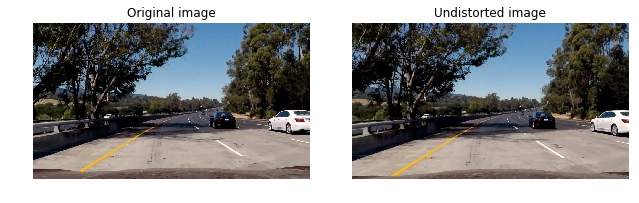

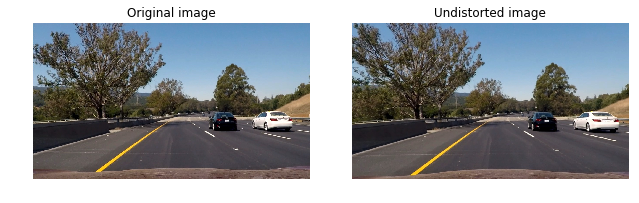

In [2]:
import pickle

#Generate distortion coefficients and camera matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#Create a dict to save mtx and dist variables as pickle
calibration_data = {
"camera_mtx": mtx, 
"distortion_coef": dist
}
#pickle.dump(calibration_data, open( "calibration_data.p", "wb" ))

#Define undistort function
def undistort(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

#Test on images
test_images = glob.glob('test_images/*.jpg')

def testrun(img):
    img=cv2.imread(img)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    undist_img=undistort(img,mtx,dist)
    f,(ax1,ax2) = plt.subplots(1, 2, figsize=(9,6))
    plt.tight_layout()
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Original image')
    ax2.imshow(undist_img)
    ax2.axis('off')
    ax2.set_title('Undistorted image')
    return 

for image in test_images:
    testrun(image)


### Perspective transform

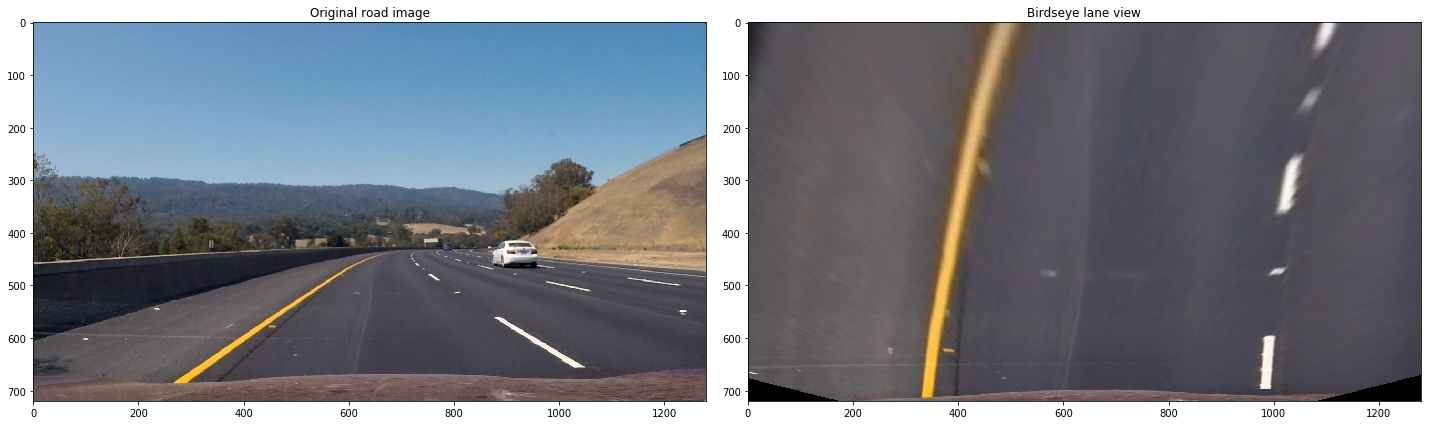

In [3]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#Define the perspective source and destination points
src=np.float32([(580,460),(205,720),(1110,720),(703,460)])

dst=np.float32([(320,0),(320,720),(960,720),(960,0)])

M=cv2.getPerspectiveTransform(src,dst) #Perspective transform map
Minv=cv2.getPerspectiveTransform(dst,src) #Inverse map
#Defining a function that transforms the lane lines into a birdseye view
def birdseyeView(img,src,dst):
    h,w=img.shape[:2]
    birdseye=cv2.warpPerspective(img,M,(w,h),flags=cv2.INTER_LINEAR) #this function takes (Width,Height) as the order, not the other way around
    return birdseye

#Lets visualize the birdseye view transformation
calib_data = pickle.load( open( "calibration_data.p", "rb" ) )
mtx = calib_data["camera_mtx"]
dist = calib_data["distortion_coef"]

#Vizualise the birdeye function
img=cv2.imread('test_images/test3.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
img_undist=undistort(img,mtx,dist)
birdseye_out=birdseyeView(img_undist,src,dst)

f, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
ax1.imshow(img)
ax1.set_title('Original road image')
ax2.imshow(birdseye_out)
ax2.set_title('Birdseye lane view')


## Color and Gradient Thresholding
Lets use Saturation from HLS color space and sobel operator in order to filter out the filter lanes better

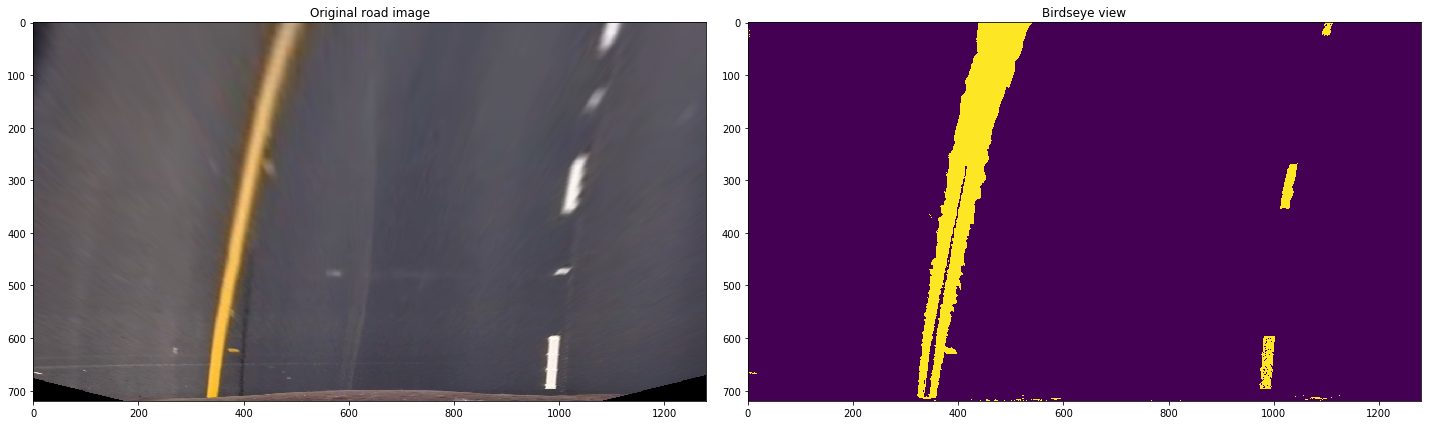

In [4]:
import matplotlib.image as mpimg

#Defining a function that does S channel and sobel X direction filtering s_thresh=(120, 200)
def colormagThresh(img, sobel_kernel=5, s_thresh=(40, 200), sx_thresh=(15, 120)): 
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #output = np.uint8(np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255)
    output=np.logical_or(s_binary,sxbinary).astype(np.uint8)
    return output

#Visualize the filtering results
image = mpimg.imread('test_images/test3.jpg')
image_undist=undistort(image,mtx,dist)
birdseye=birdseyeView(image_undist,src,dst)
binary_warped=colormagThresh(birdseye)

f, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
ax1.imshow(birdseye)
ax1.set_title('Original road image')
ax2.imshow(binary_warped)
ax2.set_title('Birdseye view')

### Lane lines polyfit


(720, 0)

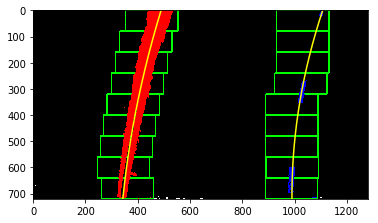

In [5]:
# Implement Sliding Windows and Fit a Polynomial function
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
def newlinepolyfit(binary_warped,nwindows=9):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) #floor division
    # Create an output image to draw on and  visualize the result
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds,leftx,lefty,rightx,righty


#Visualizing the result:
left_fit, right_fit, left_lane_inds, right_lane_inds,leftx,lefty,rightx,righty=newlinepolyfit(binary_warped) #New line fit function
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Existing Lane line poly fit function

(720, 0)

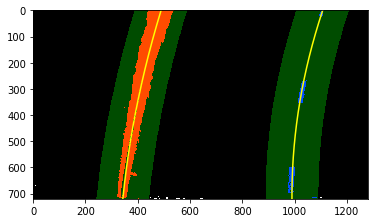

In [6]:
#Now lets define the poly fit function when the region of the probable lines are already found.

def contlinepolyfit(binary_warped,left_fit,right_fit):
    # Skip the sliding windows step once you know where the lines are
    # Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again,
    # but instead you can just search in a margin around the previous line position like this:
    margin = 100
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,leftx,lefty,rightx,righty

# And you're done! But let's visualize the result here as well
left_fit, right_fit, left_lane_inds, right_lane_inds,leftx,lefty,rightx,righty=contlinepolyfit(binary_warped,left_fit,right_fit) #Continue line fit function
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100 #Define the margin
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))
# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


### Finding curve radius

In [7]:
def findradius(binary_warped,left_fit,right_fit,leftx,lefty,rightx,righty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #Lets find the distance of the car from the center
    h=binary_warped.shape[0] #This is the height of the image. 
    #I will use h to find the position of the lane lines right in front of the hood of the car.
    car_pos = binary_warped.shape[1]/2 #Car is assumed to be in the middle of the image
    left_lane_x_pos = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2] #
    right_lane_x_pos = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (right_lane_x_pos + left_lane_x_pos) /2
    center_dist = (car_pos - lane_center_position) * xm_per_pix #in meters
    curve = (left_curverad + right_curverad)/2
    return (curve,center_dist)

curve,center_dist=findradius(binary_warped,left_fit,right_fit,leftx,lefty,rightx,righty)
print( 'Radius: ',curve , 'm')
print('Distance from the center: ',center_dist)

Radius:  942.365251645 m
Distance from the center:  -0.140097311516


### Projecting the poly fill back on the original image

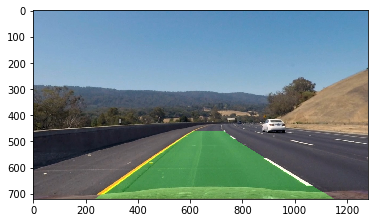

In [8]:
def polyproject(img_undist,binary_warped,left_fit,right_fit,Minv):
    image=np.copy(img_undist)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty=np.linspace(0,binary_warped.shape[0]-1,binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
out=polyproject(image_undist,binary_warped,left_fit,right_fit,Minv)
plt.imshow(out)

### Draw data to screen
Draw curvature and distance from center of the line information on screen

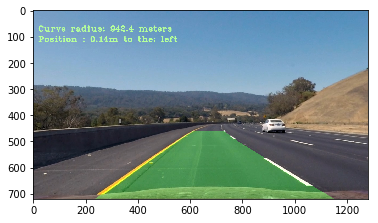

In [9]:
#Draw data function
def drawdata(image,curve,center_dist):
    img=np.copy(image)
    curve_text = 'Curve radius: ' + '{:04.1f}'.format(curve) + ' meters'
    cv2.putText(img,curve_text,(20,80),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5, (180,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    dist_text = 'Position : '+'{:02.2f}'.format(np.abs(center_dist)) + 'm' ' to the: ' + direction
    cv2.putText(img, dist_text, (20,120),cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5, (180,255,155), 2, cv2.LINE_AA)
    return img

result=drawdata(out,curve,center_dist)
plt.imshow(result)
plt.imsave('result.jpg',result)

### Define Line() class to store data

In [21]:
# Line class contains characteristics of each line detection
class Line():
    def __init__(self,n=5):
        # every n frames are buffered
        self.n = n
        #check if a previous line was detected?
        self.detected=False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #self.current_fit = deque([],maxlen=n)
        self.avg_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def set_avg_fit(self):
        fits= self.current_fit
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.avg_fit = avg

### Video processing pipeline

In [19]:
from collections import deque
# Prepare the calibration data first
src=np.float32([(580,460),(205,720),(1110,720),(703,460)])
dst=np.float32([(320,0),(320,720),(960,720),(960,0)])
M=cv2.getPerspectiveTransform(src,dst) #Perspective transform map
Minv=cv2.getPerspectiveTransform(dst,src) #Inverse map
#Lets visualize the birdseye view transformation
calib_data = pickle.load( open( "calibration_data.p", "rb" ) )
mtx = calib_data["camera_mtx"]
dist = calib_data["distortion_coef"]

def process_video(img):
    undist_img=undistort(img,mtx,dist)
    birdseye_img=birdseyeView(undist_img,src,dst)
    thresh_img=colormagThresh(birdseye_img)
    if L_Line.detected==False or R_Line.detected==False:
        L_Line.current_fit, R_Line.current_fit, left_lane_inds, right_lane_inds,leftx,lefty,rightx,righty=newlinepolyfit(thresh_img)
        if len(L_Line.current_fit)> 0:
            L_Line.detected=True
        else:
            L_Line.detected=False
        
        if len(R_Line.current_fit)> 0:
            R_Line.detected=True
        else:
            R_Line.detected=False
    else:
        L_Line.current_fit, R_Line.current_fit, left_lane_inds, right_lane_inds,leftx,lefty,rightx,righty=contlinepolyfit(thresh_img,L_Line.current_fit,R_Line.current_fit)
    
    #Average the current_fit for smoother detected lane projection
    
    L_Line.set_avg_fit
    R_Line.set_avg_fit
    left_fit = L_Line.avg_fit
    right_fit = R_Line.avg_fit
    #Find the curve and dist from center
    curve,center_dist=findradius(thresh_img,L_Line.current_fit,R_Line.current_fit,leftx,lefty,rightx,righty)
    projected_img=polyproject(undist_img,thresh_img,L_Line.current_fit,R_Line.current_fit,Minv)
    result=drawdata(projected_img,curve,center_dist)
    return result

In [20]:
from moviepy.editor import VideoFileClip

L_Line = Line()
R_Line = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

AttributeError: 'numpy.ndarray' object has no attribute 'append'